<center>
    <h1>Policy Learning with Observational Data: <i>A Tutorial</i></h1>
    <h2>Implementing Susan Athey and Stefan Wager (2021)</h2>
    <h3>Allison Towey, <i>The University of Chicago</i></h3>
</center>

### Table of Contents

- [1. Introduction](#section-1-introduction)
- [2. Getting Started](#section-2)
- [3. ***Step 1***: Estimation of Nuisance Components ](#section-3)
- [4. ***Step 2***: Computing Doubly Robust Scores](#section-4)
- [5. ***Step 3*** Fitting the Policy Tree](#section-5)
- [6. Evaluation](#section-6)

# 1. Introduction <a id="section-1-introduction"></a>

This tutorial explores the implementation of Athey and Wager's framework from **"Policy Learning with Observational Data"** (2021), which addresses the challenge of learning treatment assignment policies while considering feasibility constraints. It provides step-by-step guidance using a real dataset to facilitate the implementation of the framework in Python. The goal is to provide readers with a solid understanding of effective tools to apply policy learning methodology.

<h2>What is policy learning?</h2>

Policy learning plays a crucial role in enabling adaptive, optimal decision-making in complex and uncertain environments, with applications spanning various domains and disciplines. Accurately and efficiently learning optimal treatment assignments, which involves mapping individual characteristics to treatment assignments, is important for policy decision-making and a common challenge in applied economics and statistics.

Across various domains, practitioners seek to utilize observational data to learn treatment assignment policies that adhere to specific constraints, as the treatment assignment problem is seldom encountered in an unconstrained environment. These policies may be subject to constraints such as budget limitations, fairness considerations, simplicity requirements, or other functional requirements, which can limit the range of feasible treatment assignments. In real life applications, there may be several reasons to require that the policy belong to a restricted class of policies, such as:
<ul>
<li>Some variables such as gender or race may not be able to be used to determine the treatment allocation (ethically, or legally).</li><li> Interpretability and functional form simplicity could be important if understandability and explainability is fundamental to policy adoption and auditing.</li><li>Technical efficiency may be necessary or beneficial in order to achieve optimal performance or resource utilization.</li></ul>
    
Practitioners aim to find an optimal set of treatment assignments while considering these feasibility constraints. The objective is to minimize regret, which represents the difference between the utility of the chosen policy and the highest utility achievable among all policies within the feasible set.

<h2> Our objective </h2>

1. We would like to select a function $\pi$ that maps observed characteristics to an available treatment. This function is called a <strong>policy</strong>.


2. Using observational data, we want to learn a policy $\pi$ that maps a subject’s **characteristics**, $X_i \in X$, to a **treatment decision** $\pi: X \to ${$0, 1$}.


3. This learned policy (𝛑̂) must satisfy certain **given constraints** and belong to the set of feasible policies ($\Pi$), i.e.: 𝛑̂ ∈ $\Pi$


4. We seek guarantees on the **regret**: R(𝛑̂), or the difference between the expected utility of the learned policy 𝛑̂ and the best utility of any policy in the set of feasible policies ($\Pi$)

<h2>So, how do we do this?</h2>

Athey and Wager's <strong>"Policy Learning with Observational Data" </strong> (published 2021 in Econometrica) develops an algorithm that uses observational data to determine the best way to assign treatments to individuals given a set of constraints. Informed by the theory of semi-parametrically efficient estimation, they provide assurances that their method will result in minimal regret. 

Their method seeks to learn treatment assignment policies that can: 
<ol>
    <li> handle specified constraints and </li>
    <li> use observational (i.e. not only Random Controlled Trial) data. </li>
   </ol>
The purpose of this tutorial is to demonstrate the application of their method to a real dataset.

<h2>Setting Up Our Framework and Assumptions</h2>

### Causal Framework

Before we begin the tutorial, we set up our causal framework.

Each unit in our data set will be represented by:

- $X_i$: observable pre-treatment characteristics
- $W_i ∈{0,1}$ whether the unit was treated (1) or not treated (0)
- $Y_i^{obs} ∈ ℝ$: the observed binary outcome for that unit

The **law of total expectation**, also known as the law of iterated expectation, states that the expected value of a random variable can be calculated by taking the conditional expectation with respect to another random variable and then averaging over all possible values of that variable. 

This law is expressed as:
<center>$E[X] = E[E[X|Y]]$</center>

We additionally adopt the **potential outcome framework** introduced by Rubin (1974) to study causal relationships. This framework considers the existence of two potential outcomes for each unit: one under the treatment condition ($Y_i(1)$) and one under the control condition ($Y_i(0)$). However, in practice, we can only observe a single outcome for each individual based on whether they receive the treatment or control. This creates a "missing value" problem, where we are interested in analyzing counterfactual scenarios. We have underlying random variables including the treatment assignment ($X_i$), the potential outcome under control ($Y_i(0)$), and the potential outcome under treatment ($Y_i(1)$). But we can only observe either ($X_i, Y_i(0)$) for control units or ($X_i, Y_i(1)$) for treated units. Therefore, causal inference involves addressing this missing outcome issue to make inferences and estimate treatment effects or intervention outcomes. 

Consequently, the observed outcome can be expressed as:
<center>$Y_i^{obs}=W_iY_i(1)+(1−W_i)Y_i(0)$ </center>

### Assumptions
Additionally, we will be making two identification assumptions that will allow us to use the methods below.

#### Assumption 1: Unconfoundedness/Conditional Independence 
The unconfoundedness assumption states that the treatment assignment is independent of potential outcomes given the observed covariates or confounders. Once we account for the observable characteristics or variables that might affect both the treatment assignment and the outcome, the unconfoundedness assumption implies that there are no hidden or unobserved factors that influence both the treatment assignment and the outcome. Formally, 
<center>$Y_i(1),Y_i(0)⊥ W_i | X_i$</center>

#### Assumption 2: Positivity/Overlap
The positivity assumption states that for any combination of observed covariates or confounders, there is a non-zero probability of receiving both the treatment and the control condition.It therefore implies that there are no regions in the covariate space where all individuals are either always treated or always untreated. It ensures that there is sufficient overlap in the distribution of covariates between the treated and untreated groups, allowing for meaningful comparisons and estimation of treatment effects. Formally, 
<center>$ 0<P (W=1 | X=x)<1$</center>

# 2. Getting Started<a id="section-2"></a>

To demonstrate how to implement algorithm, let's first set up our coding environment and data.

This tutorial will use the coding language Python, along with several important libraries imported below.

In [1]:
# Turn off all warnings
import warnings
warnings.filterwarnings("ignore")

# Import libraries
# If any of these libraries are not installed, you may do so by running the command: !pip install your_library_name
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from IPython.display import SVG, display
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# We also want to set a seed for replicability
random.seed(123456)

We will be working with the 'welfare' dataset from the GSB Social Impact Lab, originally from “Modeling Heterogeneous Treatment Effects in Survey Experiments with Bayesian Additive Regression Trees” (Green and Kern 2012)

It is additionally possible to run this code with other pre-cleaned datasets from the GSB Social Impact Lab such as the social dataset from “Social Pressure and Voter Turnout” (Gerber, Green, and Larimer, 2008) and the charitable dataset from “Does Price Matter in Charitable Giving?” (Karlan and List, 2007).

The data provided by the GSB Social Impact Lab is largely pre-cleaned, so there are relatively few data-cleaning or generating processes needed.

In [2]:
# Read in our data
df = pd.read_csv('https://raw.githubusercontent.com/gsbDBI/ExperimentData/master/Welfare/ProcessedData/welfarenolabel3.csv')

In [3]:
# Check which variables we are working with
list(df.columns)

['year',
 'id',
 'wrkstat',
 'hrs1',
 'hrs2',
 'evwork',
 'occ',
 'prestige',
 'wrkslf',
 'wrkgovt',
 'commute',
 'occ80',
 'prestg80',
 'indus80',
 'marital',
 'agewed',
 'divorce',
 'widowed',
 'spwrksta',
 'sphrs1',
 'sphrs2',
 'spevwork',
 'spocc80',
 'sppres80',
 'spind80',
 'sibs',
 'childs',
 'age',
 'agekdbrn',
 'educ',
 'paeduc',
 'maeduc',
 'speduc',
 'degree',
 'padeg',
 'madeg',
 'spdeg',
 'sex',
 'race',
 'res16',
 'reg16',
 'mobile16',
 'family16',
 'mawork',
 'mawkborn',
 'born',
 'parborn',
 'granborn',
 'hompop',
 'babies',
 'preteen',
 'teens',
 'adults',
 'unrelat',
 'earnrs',
 'income',
 'rincome',
 'income86',
 'partyid',
 'polviews',
 'w',
 'y',
 '_merge',
 'wrkstat_miss',
 'hrs1_miss',
 'hrs2_miss',
 'evwork_miss',
 'wrkslf_miss',
 'wrkgovt_miss',
 'commute_miss',
 'occ80_miss',
 'indus80_miss',
 'agewed_miss',
 'divorce_miss',
 'widowed_miss',
 'spwrksta_miss',
 'sphrs1_miss',
 'sphrs2_miss',
 'spevwork_miss',
 'spocc80_miss',
 'spind80_miss',
 'sibs_miss',
 'ag

We want to select our relevant variables, which in this case, is
- our **outcome** variable ($Y$), (denoted by ```'y'``` in this dataset)
- our **treatment** variable ($W$) (denoted by ```'w'``` in this dataset)
- our relevant pre-treatment **covariates** ($X$) (in this case ```'marital', 'age', 'sex', 'educ', 'polviews', 'partyid', 'race'```)

We then can subset our dataframe to only include relevant columns in our dataframe, drop observations (rows) with missing information, and cast all variables to numeric for ease of analysis.

In [4]:
# Assign variables
outcome = 'y'
treatment = 'w'
covariates = ['marital', 'age', 'sex', 'educ', 'polviews', 'partyid', 'race']

all_variable_names = [outcome, treatment] + covariates

# Select the relevant columns from the dataframe and remove all others
df = df[all_variable_names]

# Remove rows with N/A values
# In this dataframe, values that are missing/undefined are denoted as -999
df = df[df != -999].dropna().reset_index(drop=True) 

# Cast all variables to numeric
df = df.apply(pd.to_numeric, errors='coerce')

Now let's check out what a sample of our dataset looks like. Each row is a sample that has an outcome ($Y_i$), a treatment assignment ($W$), and covariates ($X$).

In [5]:
df.head()

,y,w,marital,age,sex,educ,polviews,partyid,race
0,0,0,5.0,28.0,1,14.0,4.0,3.0,1
1,1,0,2.0,54.0,2,16.0,6.0,6.0,1
2,1,0,5.0,44.0,2,16.0,2.0,0.0,1
3,0,0,4.0,77.0,2,14.0,4.0,0.0,2
4,0,0,4.0,44.0,2,14.0,4.0,0.0,2


Before we get started, we might want to see the summary statistics for the data. For instance see in this case that treatment was assigned to about half (54%) of the sample rows, as seen by the mean of ```'w'``` being $.5350$.

For more information about what these data mean, consult the dataset or codebook as available. 

In [6]:
# Calculate summary statistics
summ_stats = pd.DataFrame(df.describe().transpose())
summ_stats.transpose()

,y,w,marital,age,sex,educ,polviews,partyid,race
count,33269.000000,33269.000000,33269.000000,33269.000000,33269.000000,33269.000000,33269.000000,33269.000000,33269.000000
mean,0.251916,0.535003,2.401365,46.065376,1.560702,13.117016,4.121918,2.815113,1.271274
std,0.434120,0.498781,1.632836,17.376747,0.496309,3.072417,1.355477,2.045163,0.571842
min,0.000000,0.000000,1.000000,18.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,0.000000,1.000000,32.000000,1.000000,12.000000,3.000000,1.000000,1.000000
50%,0.000000,1.000000,2.000000,43.000000,2.000000,13.000000,4.000000,3.000000,1.000000
75%,1.000000,1.000000,4.000000,59.000000,2.000000,15.000000,5.000000,5.000000,1.000000
max,1.000000,1.000000,5.000000,89.000000,2.000000,20.000000,7.000000,7.000000,3.000000


Next, we should set up training and testing sets. We will use the training set to fit the model and the testing set to see how our model performs on data it has not seen. 

In [7]:
# Set up a training and testing set from the scikit-learn package
train_fraction = 0.80  # Use train_fraction % of the dataset to train our models and the rest to test
df_train, df_test = train_test_split(df, train_size=train_fraction)

# 3. ***Step 1***: Estimation of Nuisance Components <a id="section-3"></a>

The first step is to estimate the nuisance components:

- Estimating $g(x, z)$ involves fitting a model that predicts the treatment $W$, given the covariates $X$ and any additional controls $Z$. We call this the propensity estimator or ```propensity.forest``` in the code.
<center>$g(x, z) = E[W | X = x, Z = z]$</center>


- Estimating $m(x, w)$ involves fitting a model that predicts the potential outcome $Y$ under different levels of treatment, given the covariates $X$. We call this the outcome estimator or ```outcome.forest``` in the code.
<center>$m(x, w) = E[Y | X = x, W = w]$</center>


Note that the choice of estimator for $m(x, w)$ and $g(x, z)$ in this step and the choice of policy class $Π$ along with the optimizer used in Step 3 can be made fully independently.

We will be using a **Regression Forest** from R's ```grf``` package to fit a model and estimate the nuisance components. A regression forest is is an ensemble method that utilizes multiple decision trees trained on different subsets of the dataset. By employing averaging techniques, it enhances predictive accuracy and mitigates overfitting issues. For more information about ```regression_forest```, see https://www.rdocumentation.org/packages/grf/versions/0.10.2/topics/regression_forest

We can use this R method in Python by using the Python library ```rpy2```. We grab our $X$, $Y$, and $X$ data from the training set, fit the models, and then use the fitted model to make $\hat{Y}$ and $\hat{W}$ predictions.

In [8]:
# Activate rpy2
pandas2ri.activate()

In [9]:
# Grab our data for the covariate variables, outcome variable, and treatment variable from our training and test sets
X = df_train[covariates]
Y = df_train[outcome]
W = df_train[treatment]
X_test = df_test[covariates]
Y_test = df_test[outcome]
W_test = df_test[treatment]

# Convert DataFrame to R objects
X_r = pandas2ri.py2rpy(X)
Y_r = pandas2ri.py2rpy(Y)
W_r = pandas2ri.py2rpy(W)
X_test_r = pandas2ri.py2rpy(X_test)

# Assign R objects to global environment
robjects.globalenv["X_r"] = X_r
robjects.globalenv["Y_r"] = Y_r
robjects.globalenv["W_r"] = W_r
robjects.globalenv["X_test_r"] = X_test_r

#Fit our regression forests in R and find W_hat and Y_hat for training and test sets
robjects.r('''
library(grf)
tune.parameters = c("mtry", "min.node.size", "alpha", "imbalance.penalty")
propensity.forest = regression_forest(X_r, W_r, tune.parameters = tune.parameters)
W_hat = predict(propensity.forest)$predictions
W_hat.test <- predict(propensity.forest, newdata=X_test_r)$predictions

outcome.forest = regression_forest(X_r, Y_r, tune.parameters = tune.parameters)
Y_hat = predict(outcome.forest)$predictions
Y_hat.test = predict(outcome.forest, newdata=X_test_r)$predictions
''')

# Convert Y_hat and W_hat to Python objects
Y_hat = robjects.r['Y_hat'].flatten()
W_hat = robjects.r['W_hat'].flatten()
Y_hat_test = robjects.r['Y_hat.test'].flatten()
W_hat_test = robjects.r['W_hat.test'].flatten()

# Convert Y_hat and W_hat to NumPy Arrays for ease of use in Python
Y_hat = np.array(Y_hat)
W_hat = np.array(W_hat)
Y_hat_test = np.array(Y_hat_test)
W_hat_test = np.array(W_hat_test)

# 4. ***Step 2***: Computing Doubly Robust Scores <a id="section-4"></a>

We have now fit models and estimated our nuisance paramenters. The next step is to compute doubly robust scores.

To predict treatment effects, we can use the **Causal Forest** model, which is implemented in ```grf```'s ```causal_forest``` in R, transferred to Python using ```rpy2```. This model builds upon the random forest framework by training multiple decision trees on different subsets of the data. In addition to standard predictions, causal forests specifically focus on estimating the causal effect of a treatment or intervention on an outcome variable. They leverage the heterogeneity present in the data and incorporate the propensity score, which represents the probability of treatment assignment, to estimate average treatment effects and other causal effects of interest. You can find more information here: https://grf-labs.github.io/grf/reference/causal_forest.html

We use these treatment effects to find our doubly robust scores, $\hat{\Gamma}_i$.

<center>$\hat{\Gamma}_i = \hat{\tau}_{-i}(X_i) + W_i - \hat{e}_{-i}(X_i)\hat{e}_{-i}(X_i)(1 - \hat{e}_{-i}(X_i))(Y_i - \hat{\mu}_{-i}W_i)$</center>

In the above equation, 
- $\hat{\tau}(\cdot)$ treatment effect estimates, 
- $\hat{e}(\cdot)$: propensity score estimates
- $\hat{\mu}_0$, $\hat{\mu}_1$: estimates of $E[Y|X_i,W_i=0]$ and $E[Y|X_i,W_i=1]$ respectively. 
- *Note:* $-i$ indicates that the estimate for observation $i$ is an out-of-bag (OOB) estimate.

The use of doubly robust scores offers two **key advantages**:

1. They provide protection against model misspecification: if either the outcome model or the propensity score model is correctly specified, the average of the doubly robust scores consistently estimates the average treatment effect. 

2. Their average achieves the semi-parametric lower bound as an estimation of the average treatment effect. This semi-parametric efficiency translates into provable theoretical guarantees on the performance of the optimal estimated policy.

We will compute scores for the training and testing sets.

In [10]:
# In R, fit a causal forest model and obtain estimated treatment effects
robjects.r(
    '''
    library(grf)
    tune.parameters = c("mtry", "min.node.size", "alpha", "imbalance.penalty")
    cf = causal_forest(X_r, Y_r, W_r, Y.hat = Y_hat, W.hat = W_hat, tune.parameters = tune.parameters)

    # Obtain the estimated treatment effect
    tauhat = predict(cf)$predictions
    tauhat.test <- predict(cf, newdata=X_test_r)$predictions
    ''')

# Convert output to Python NumPy array
tau_hat = robjects.r['tauhat'].flatten()
tau_hat = np.array(tau_hat)
tau_hat_test = robjects.r['tauhat.test'].flatten()
tau_hat_test = np.array(tau_hat_test)

In [11]:
# Estimate E[Y|X=x, W=0] and E[Y|X=x, W=1] for training set
mu_hat_0 = Y_hat - W_hat * tau_hat
mu_hat_1 = Y_hat + (1 - W_hat) * tau_hat

In [12]:
#Estimate Gamma_hat using our mu_hat_0 and mu_hat_1 for training set
resid = Y - W * mu_hat_1 - (1 - W) * mu_hat_0
weights = (W - W_hat) / (W_hat * (1 - W_hat))
Gamma_hat = tau_hat + weights * resid

In [13]:
Gamma_hat #Let's look at our scores for the training set

11540   -0.446005
19699   -0.348049
32634   -0.503020
30150    0.537836
17196   -0.469412
           ...   
8663    -0.575906
27869   -0.705942
2642    -0.472470
29070   -0.451484
30814   -0.395903
Length: 26615, dtype: float64

In [14]:
# Estimate E[Y|X=x, W=0] and E[Y|X=x, W=1] for test set
mu_hat_0_test = Y_hat_test - W_hat_test * tau_hat_test
mu_hat_1_test = Y_hat_test + (1 - W_hat_test) * tau_hat_test

In [15]:
#Estimate Gamma_hat using our mu_hat_0 and mu_hat_1 for test set
resid_test = Y_test - W_test * mu_hat_1_test - (1 - W_test) * mu_hat_0_test
weights_test = (W_test - W_hat_test) / (W_hat_test * (1 - W_hat_test))
Gamma_hat_test = tau_hat_test + weights_test * resid_test

In [16]:
Gamma_hat_test #Let's look at our test set scores

29590   -0.298898
17002   -0.201816
18485    0.757932
17866    0.995479
5410    -1.468764
           ...   
21142   -0.390404
8342    -0.425066
6709    -0.766035
30450    0.550738
11857    1.331888
Length: 6654, dtype: float64

Now that we have obtained the scores, we subtract the treatment cost. In real world applications, the true cost of treatment would be subtracted. However, for illustrative purposes, we calibrate the cost for this tutorial by setting it equal to the median of the CATE (Conditional Average Treatment Effect) estimates. This calibration ensures that a portion of the population is assigned to receive treatment while others are not, thereby creating a nontrivial policy.

In [17]:
# Define cost to be median CATE
cost = np.median(tau_hat)

In [18]:
#Subtract the cost from the Gamma scores
Gamma_hat_net = Gamma_hat - cost
Gamma_hat_test_net = Gamma_hat_test - cost

# 5. ***Step 3*** Fitting the Policy Tree <a id="section-5"></a>

Next, we prepare our data for the policy tree. A policy tree is a decision tree-based algorithm that is specifically designed to learn optimal decision-making policies in sequential decision problems. Given doubly robust reward estimates, we use policy trees to find a rule-based treatment assignment policy, where the policy takes the form of a shallow decision tree that is globally (or close to) optimal. 

Using doubly robust scores we found, we now aim to find a policy in the set of feasible policies ($\pi \in \Pi$) that maximizes the objective function:

<center>$\pi^* = \arg\max_{\pi \in \Pi} \left[ \frac{1}{n} \sum_{i=1}^{n} \Gamma_i(\pi(X_i)) \right]$</center>
where:

- $\pi^*$ represents the estimated optimal policy,
- $\arg\max_{\pi \in \Pi}$ denotes the maximization over the set of policies $\Pi$,
- $\frac{1}{n} \sum_{i=1}^{n} \Gamma_i(\pi(X_i))$ is the average of the doubly robust scores $\Gamma_i(\pi(X_i))$ over all observations.


In this tutorial, we will be using the R package ```policytree```, developed by Athey and Wager and co-authors and used in "Policy Learning with Observational Data" (2021) for this precise purpose. For more information, see https://cran.r-project.org/web/packages/policytree/index.html

We should determine what our class of feasible policies is. Let's first look at a policy tree that is constrained to have a depth of 1.

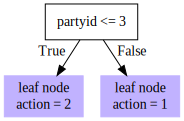

In [19]:
# Set up our Gamma hat nets for implementation in the policy tree
Gamma_hat_net_r = pandas2ri.py2rpy(Gamma_hat_net)
robjects.globalenv["Gamma_hat_net_r"] = Gamma_hat_net_r

#Use policytree to find optimal tree that is within class (depth 1)
robjects.r(
    '''
    library(policytree)
    library(DiagrammeRsvg)
    
    # policy_tree takes in our X, our doubly robust estimates, and our chosen tree depth
    tree.1 <- policy_tree(X_r, cbind(-Gamma_hat_net_r, Gamma_hat_net_r), depth = 1)
    policy.1 <- predict(tree.1, X_r) - 1
    tree.plot = plot(tree.1, leaf.names=c('control', 'treatment'))
    cat(DiagrammeRsvg::export_svg(tree.plot), file = 'plot.svg')
    ''')

# Read the SVG file
with open('plot.svg', 'r') as svg_file:
    svg_data = svg_file.read()

# Display the SVG
display(SVG(svg_data))

As we see in this plot, we get an optimal policy tree that splits on the variable partyid, with units with partyid <= 3 receiving treatment and units with partyid > 3 recieving control.

- **```Action 1``` denotes control and ```Action 2``` denotes treatment.**
- If you would like to see the predicted assignments for each row, you can print ```policy.1```

Now let's say we want to constrain our feasible policies to depth of 2 trees.

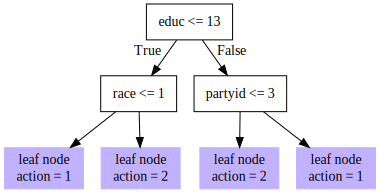

In [20]:
#Use policytree to find optimal tree that is within class (depth 2)
robjects.r(
    '''
    tree.2 <- policy_tree(X_r, cbind(-Gamma_hat_net_r, Gamma_hat_net_r), depth = 2)
    policy.2 <- predict(tree.2, X_r) - 1
    tree.2.plot = plot(tree.2, leaf.names=c('control', 'treatment'))
    cat(DiagrammeRsvg::export_svg(tree.2.plot), file = 'plot2.svg')
    ''')

# Read the SVG file
with open('plot2.svg', 'r') as svg_file:
    svg_data = svg_file.read()

# Display the SVG
display(SVG(svg_data))

In this case, we first split on education. 
- If education is <= 13 and race <= 1, we assign control. 
- If education is <= 13 and race > 1, we assign treatment. 
- If education is > 14 and partyid <= 3, we assign treatment.
- If education is > 14 and partyid > 3, we assign control. 

In this case, it looks like we are splitting on race. Perhaps for ethical or legal reasons, we don't want our tree to split on race, age, or gender variables. We can limit our splitting variables by making a subset of the dataframe with possible split variables and performing the analysis on them.

In [21]:
sensitive_features = ["sex", "race", "age"]
safe_features = [feature for feature in X.columns if feature not in sensitive_features]
X_safe = X[safe_features]

In [22]:
X_safe.columns # Our possible splitting variables

Index(['marital', 'educ', 'polviews', 'partyid'], dtype='object')

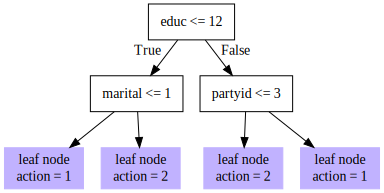

In [23]:
# Convert to R object and assign to global environment
X_safe_r = pandas2ri.py2rpy(X_safe)
robjects.globalenv["X_safe_r"] = X_safe_r

#Use policytree to find optimal tree that is within class (safe variables only; depth 2)
robjects.r(
    '''
    tree.safe <- policy_tree(X_safe_r, cbind(-Gamma_hat_net_r, Gamma_hat_net_r), depth = 2)
    policy.safe <- predict(tree.safe, X_safe_r)
    tree.safe.plot = plot(tree.safe, leaf.names=c('control', 'treatment'))
    cat(DiagrammeRsvg::export_svg(tree.safe.plot), file = 'plot3.svg')
    ''')

# Read the SVG file
with open('plot3.svg', 'r') as svg_file:
    svg_data = svg_file.read()

# Display the SVG
display(SVG(svg_data))

Notice that we no longer are splitting on sensitive characteristics.

# 6. Evaluation <a id='section-6'></a>

Now that we have a policy, how can we evaluate it?

The **improvement** of a policy $π$ over a random policy can be calculated as the difference between their values. The **value** of a policy is the expected benefit it provides over treating no one. We can express this improvement formally as:

<center>$A(π) = V(π) - V(π_{random})$</center>

We also know that
- $V(π)$, which equals $E[π(X_i)τ(X_i)]$, is the value of policy π, which is the expected treatment effect when applying the policy
- $V(π_{random})$, which equals $\frac{1}{2}E[τ(Xi)]+\frac{1}{2}0 = \frac{1}{2} E[τ(Xi)]$, is the value when treatment and non-treatment are assigned with equal probability.

To calculate the improvement, we substitute the expressions for the values into the equation (scaled by 2 for simplification convenience):

$A(\pi) = 2(V(\pi) - V(\pi_{\text{random}})) $

$= 2(E[\pi(X_i)\tau(X_i)] - \frac{1}{2}E[\tau(X_i)]) $

$= 2E[\tau(X_i)|\pi(X_i)=1]P(\pi(X_i)=1) - (E[\tau(X_i)|\pi(X_i)=1]P(\pi(X_i)=1) + E[\tau(X_i)|\pi(X_i)=0]P(\pi(X_i)=0) $

$= E[\tau(X_i)|\pi(X_i)=1]P(\pi(X_i)=1) - E[\tau(X_i)|\pi(X_i)=0]P(\pi(X_i)=0)$


Each term in the expression represents the conditional expectation of the treatment effect under the corresponding policy assignment $(π(X_i)=1$ or $π(X_i)=0)$ weighted by the probability of that assignment. This simplified expression represents the difference in the expected treatment effects for those assigned treatment minus the average treatment effect for those assigned no treatment, weighted by their respective probabilities. We will use this method to evaluate our model.

We will use ```policytree```'s ```.predict``` method to predict optimal assignment and then calculate the value of the policy over random.

For illustration purposes, we will show evaluation for the tree with ```depth = 2```. We use the ```psych``` R packages to give us descriptive statistics about evaluation. We will output the doubly robust estimated benefit of optimal tree policy versus random policy.

In [24]:
# Convert to R object and assign to global environment
Gamma_hat_net_r = pandas2ri.py2rpy(Gamma_hat_net)
robjects.globalenv["Gamma_hat_net_r"] = Gamma_hat_net
Gamma_hat_test_net_r = pandas2ri.py2rpy(Gamma_hat_test_net)
robjects.globalenv["Gamma_hat_test_net_r"] = Gamma_hat_test_net

#Calculate Perfomances
robjects.r("""
library(psych) 
tree.assignment.train <- as.numeric(as.character(predict(tree.2, newdata = X_r, type="node.id")))
tree.assignment.test <- as.numeric(as.character(predict(tree.2, newdata = X_test_r, type="node.id")))

# Calculate value over random policy and print out results
tree.A.hat <- data.frame(rbind(
  "Optimal Tree Performance - Train" = describe(tree.assignment.train*Gamma_hat_net_r)[c("mean", "se")],
  "Optimal Tree Performance - Test"  = describe(tree.assignment.test*Gamma_hat_test_net_r)[c("mean", "se")]))
tree.A.hat$lower.ci <- with(tree.A.hat, mean - 1.96 * se)
tree.A.hat$upper.ci <- with(tree.A.hat, mean + 1.96 * se)
colnames(tree.A.hat) <- c("A.hat", "SE", "Lower CI", "Upper CI")
print(tree.A.hat)
"""         )

                                        A.hat         SE   Lower CI   Upper CI
Optimal Tree Performance - Train  0.003500206 0.02610541 -0.0476664 0.05466681
Optimal Tree Performance - Test  -0.004116695 0.05241322 -0.1068466 0.09861322


,A.hat,SE,Lower CI,Upper CI
Optimal Tree Performance - Train,0.003500,0.026105,-0.047666,0.054667
Optimal Tree Performance - Test,-0.004117,0.052413,-0.106847,0.098613


As a note, this policy tree was fit on the training data, so the training sample estimate may be biased upwards.

We can evaluate any of our trees using this method to uncover our estimated improvement of our optimal policy trees in the policy class over random.